In [43]:
import gc
import datetime
import time
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

%matplotlib inline
from c_utils_tmp.c_utils import split_data, create_inputs, create_outputs

In [26]:
def get_market_data(market, tag=True):
    market_data = pd.read_html("https://coinmarketcap.com/currencies/" + market + 
                             "/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"), flavor='html5lib')[0]
    
    
    market_data = market_data.assign(Date=pd.to_datetime(market_data['Date']))
    
    market_data['Volume'] = (pd.to_numeric(market_data['Volume'], errors='coerce').fillna(0))
    
    if tag:
        market_data.columns = [market_data.columns[0]] + [tag + '_' + i for i in market_data.columns[1:]]
    
    return market_data


def show_plot(data, tag):
  
    fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
  
    ax1.set_ylabel('Closing Price ($)',fontsize=12)
    ax2.set_ylabel('Volume ($ bn)',fontsize=12)
    ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
    ax2.set_yticklabels(range(10))
    ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
    ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
    ax1.plot(data['Date'].astype(datetime.datetime),data[tag +'_Open'])
    ax2.bar(data['Date'].astype(datetime.datetime).values, data[tag +'_Volume'].values)
    fig.tight_layout()
    plt.show()

In [27]:
btc_data = get_market_data("bitcoin", tag='btc')

In [28]:
btc_data.head(5)

,Date,btc_Open,btc_High,btc_Low,btc_Close,btc_Volume,btc_Market Cap
0,2018-03-14,9214.65,9355.85,8068.59,8269.81,6.438230e+09,155891000000
1,2018-03-13,9173.04,9470.38,8958.19,9194.85,5.991140e+09,155168000000
2,2018-03-12,9602.93,9937.50,8956.43,9205.12,6.457400e+09,162421000000
3,2018-03-11,8852.78,9711.89,8607.12,9578.63,6.296370e+09,149716000000
4,2018-03-10,9350.59,9531.32,8828.47,8866.00,5.386320e+09,158119000000


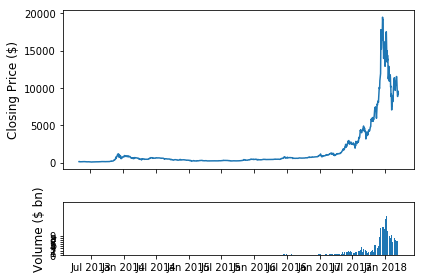

In [29]:
show_plot(btc_data,'btc')

In [31]:
train_set, test_set = split_data(btc_data)

In [34]:
train_set = train_set.drop('Date',1)
test_set = test_set.drop('Date',1)

In [46]:
print(train_set.columns)
X_train_btc = create_inputs(train_set,window_len=5,coins=['btc'])
Y_train_btc = create_outputs(test_set, window_len=5, coin=['btc'])

Index(['btc_Open', 'btc_High', 'btc_Low', 'btc_Close', 'btc_Volume',
       'btc_Market Cap'],
      dtype='object')


TypeError: can only concatenate list (not "str") to list

In [59]:
(test_set['btc_Close'][5:].values / test_set['btc_Close'][:-5] .values)

array([ 0.91472605,  0.86327245,  0.84910073,  0.79817592,  0.70827596,
        0.96499488,  1.0942617 ,  1.06720175,  1.09395415,  1.26488307,
        1.01084182,  0.98152685,  0.97267589,  1.03882736,  0.98937022,
        1.02846737,  1.10444774,  1.13389303,  0.98507463,  1.2709628 ,
        1.26864666,  1.18779649,  1.13234612,  1.19904932,  0.98391956,
        1.00830593,  1.04538832,  1.09542644,  1.10146184,  1.10432379,
        1.0804219 ,  1.03100559,  1.03791292,  1.01563379,  1.00475353,
        0.98690499,  1.0129771 ,  0.96757765,  0.99533302,  1.04691615,
        1.06008379,  1.04681613,  1.08148028,  0.88975602,  0.85200193,
        0.82532193,  0.86800744,  0.87260393,  0.96234302,  0.96589523,
        1.10297491,  1.04604592,  0.985361  ,  1.03235507,  1.14041221,
        1.03430062,  1.0344389 ,  1.07396893,  1.17042471,  1.0625331 ,
        0.96591127,  1.04063742,  1.09007022,  1.0462576 ,  1.03158658,
        1.11347565,  1.09310747,  1.16272669,  1.19217949,  1.21

In [58]:
test_set['btc_Close'][:] .values

array([  501.56,   479.64,   495.96,   527.39,   515.59,   458.79,
         414.06,   421.12,   420.95,   365.18,   442.73,   453.09,
         449.42,   460.5 ,   461.91,   447.53,   444.72,   437.14,
         478.38,   457.  ,   460.27,   491.17,   495.67,   471.24,
         580.83,   583.92,   583.41,   561.27,   565.04,   571.49,
         588.77,   609.89,   614.83,   622.37,   631.11,   636.12,
         628.8 ,   638.14,   632.1 ,   634.11,   627.79,   636.96,
         617.45,   629.15,   663.86,   665.51,   666.78,   667.76,
         559.79,   565.61,   549.26,   578.77,   582.69,   538.71,
         546.32,   605.82,   605.42,   574.16,   556.14,   623.03,
         626.6 ,   626.27,   616.63,   650.92,   661.99,   605.24,
         651.72,   672.17,   681.03,   682.9 ,   673.92,   712.4 ,
         781.55,   811.91,   827.96,   823.83,   825.37,   832.58,
         829.92,   819.03,   826.  ,   812.51,   771.39,   885.28,
         853.61,   797.07,   822.04,   845.59,   863.91,   870